In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical

from IPython.display import SVG, Image

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)


In [4]:
from torch import audi

In [5]:
# read dataset
df = pd.read_csv('C:\\Users\\DELL\\Downloads\\CNN\\icml_face_data.csv')
df.columns = ['emotion', 'Usage', 'pixels']
df.head()


NameError: name 'pd' is not defined

In [ ]:
df.emotion.value_counts()

In [ ]:
# df.columns()

In [ ]:
df.Usage.value_counts()
# df.iloc[:,1].value_counts()

<AxesSubplot:xlabel='Usage', ylabel='count'>

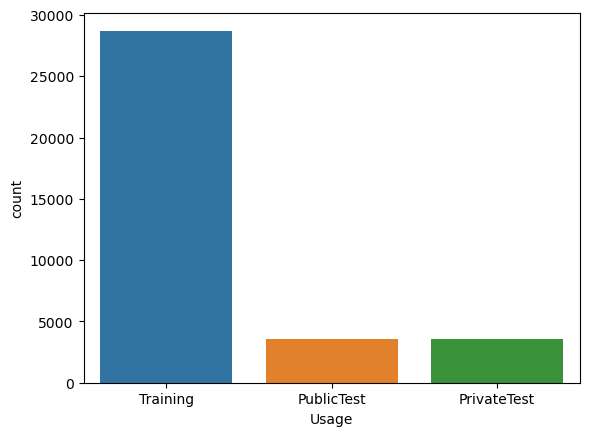

In [9]:
sns.countplot(x = df['Usage'])

In [10]:
# labels
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}
emotions            

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

[Text(0, 0, 'Angry'),
 Text(1, 0, 'Disgust'),
 Text(2, 0, 'Fear'),
 Text(3, 0, 'Happy'),
 Text(4, 0, 'Sad'),
 Text(5, 0, 'Surprise'),
 Text(6, 0, 'Neutral')]

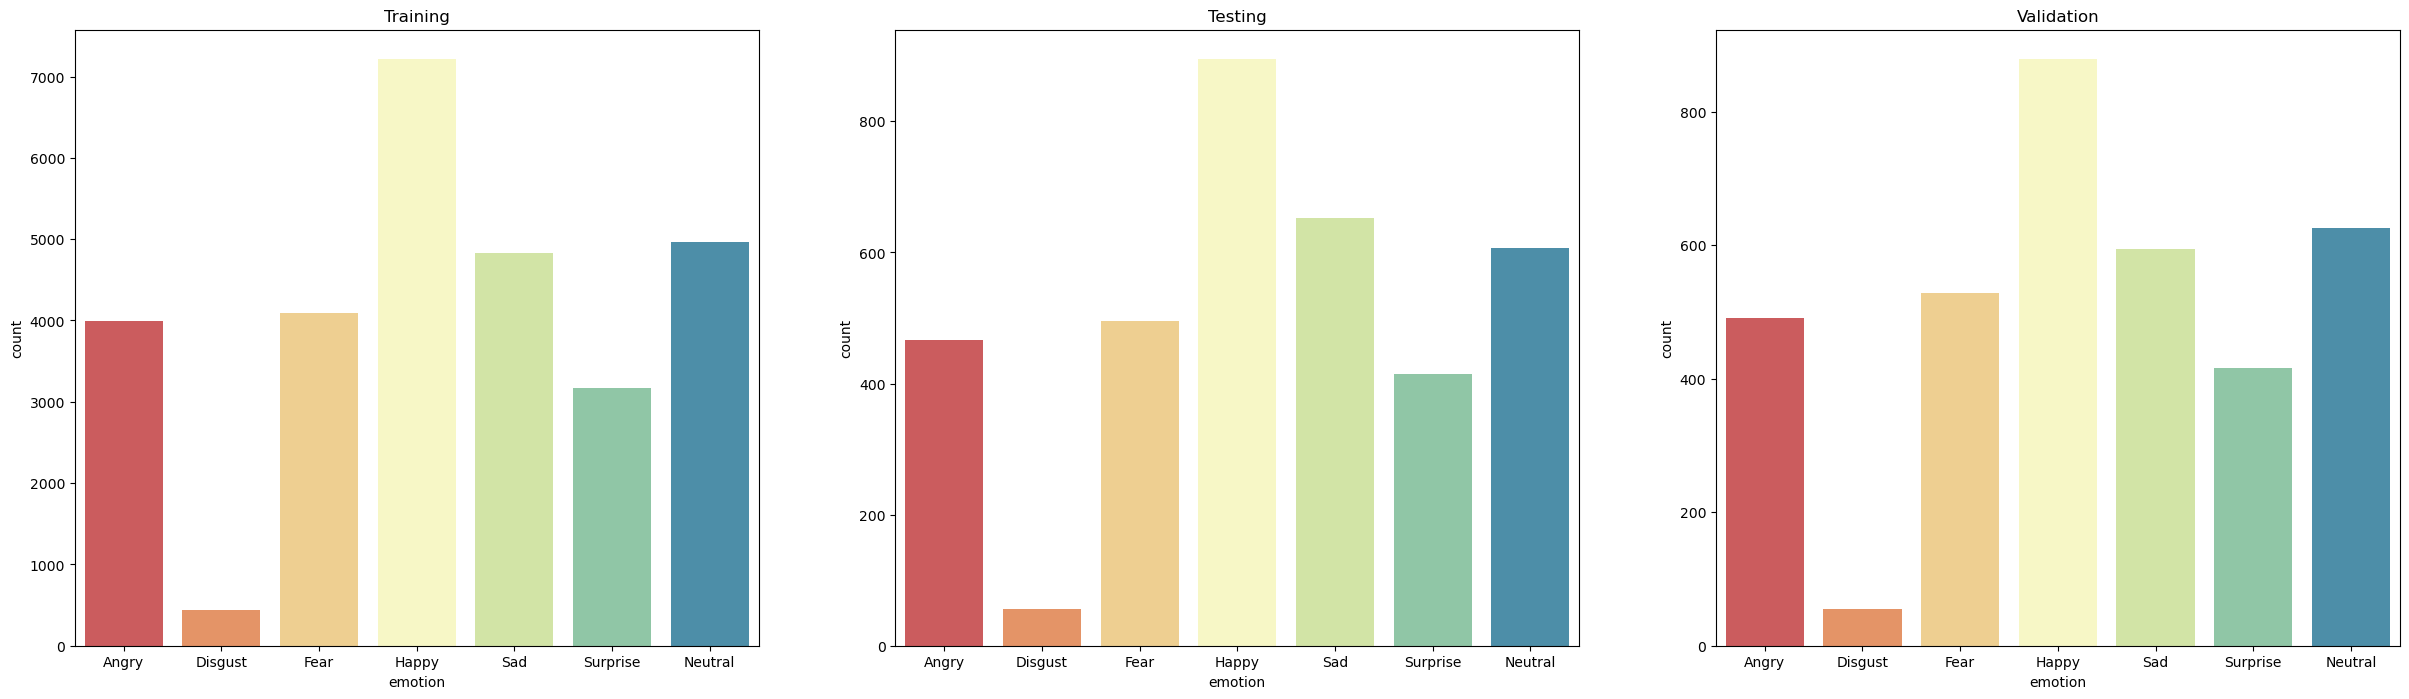

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(30,8))

sns.countplot(data = df[df['Usage']=='Training'], x='emotion', ax=ax1, palette='Spectral').set_title('Training')
ax1.set_xticklabels(emotions.values())

sns.countplot(data = df[df['Usage']=='PublicTest'], x='emotion', ax=ax2, palette='Spectral').set_title('Testing')
ax2.set_xticklabels(emotions.values())

sns.countplot(data = df[df['Usage']=='PrivateTest'], x='emotion', ax=ax3, palette='Spectral').set_title('Validation')
ax3.set_xticklabels(emotions.values())

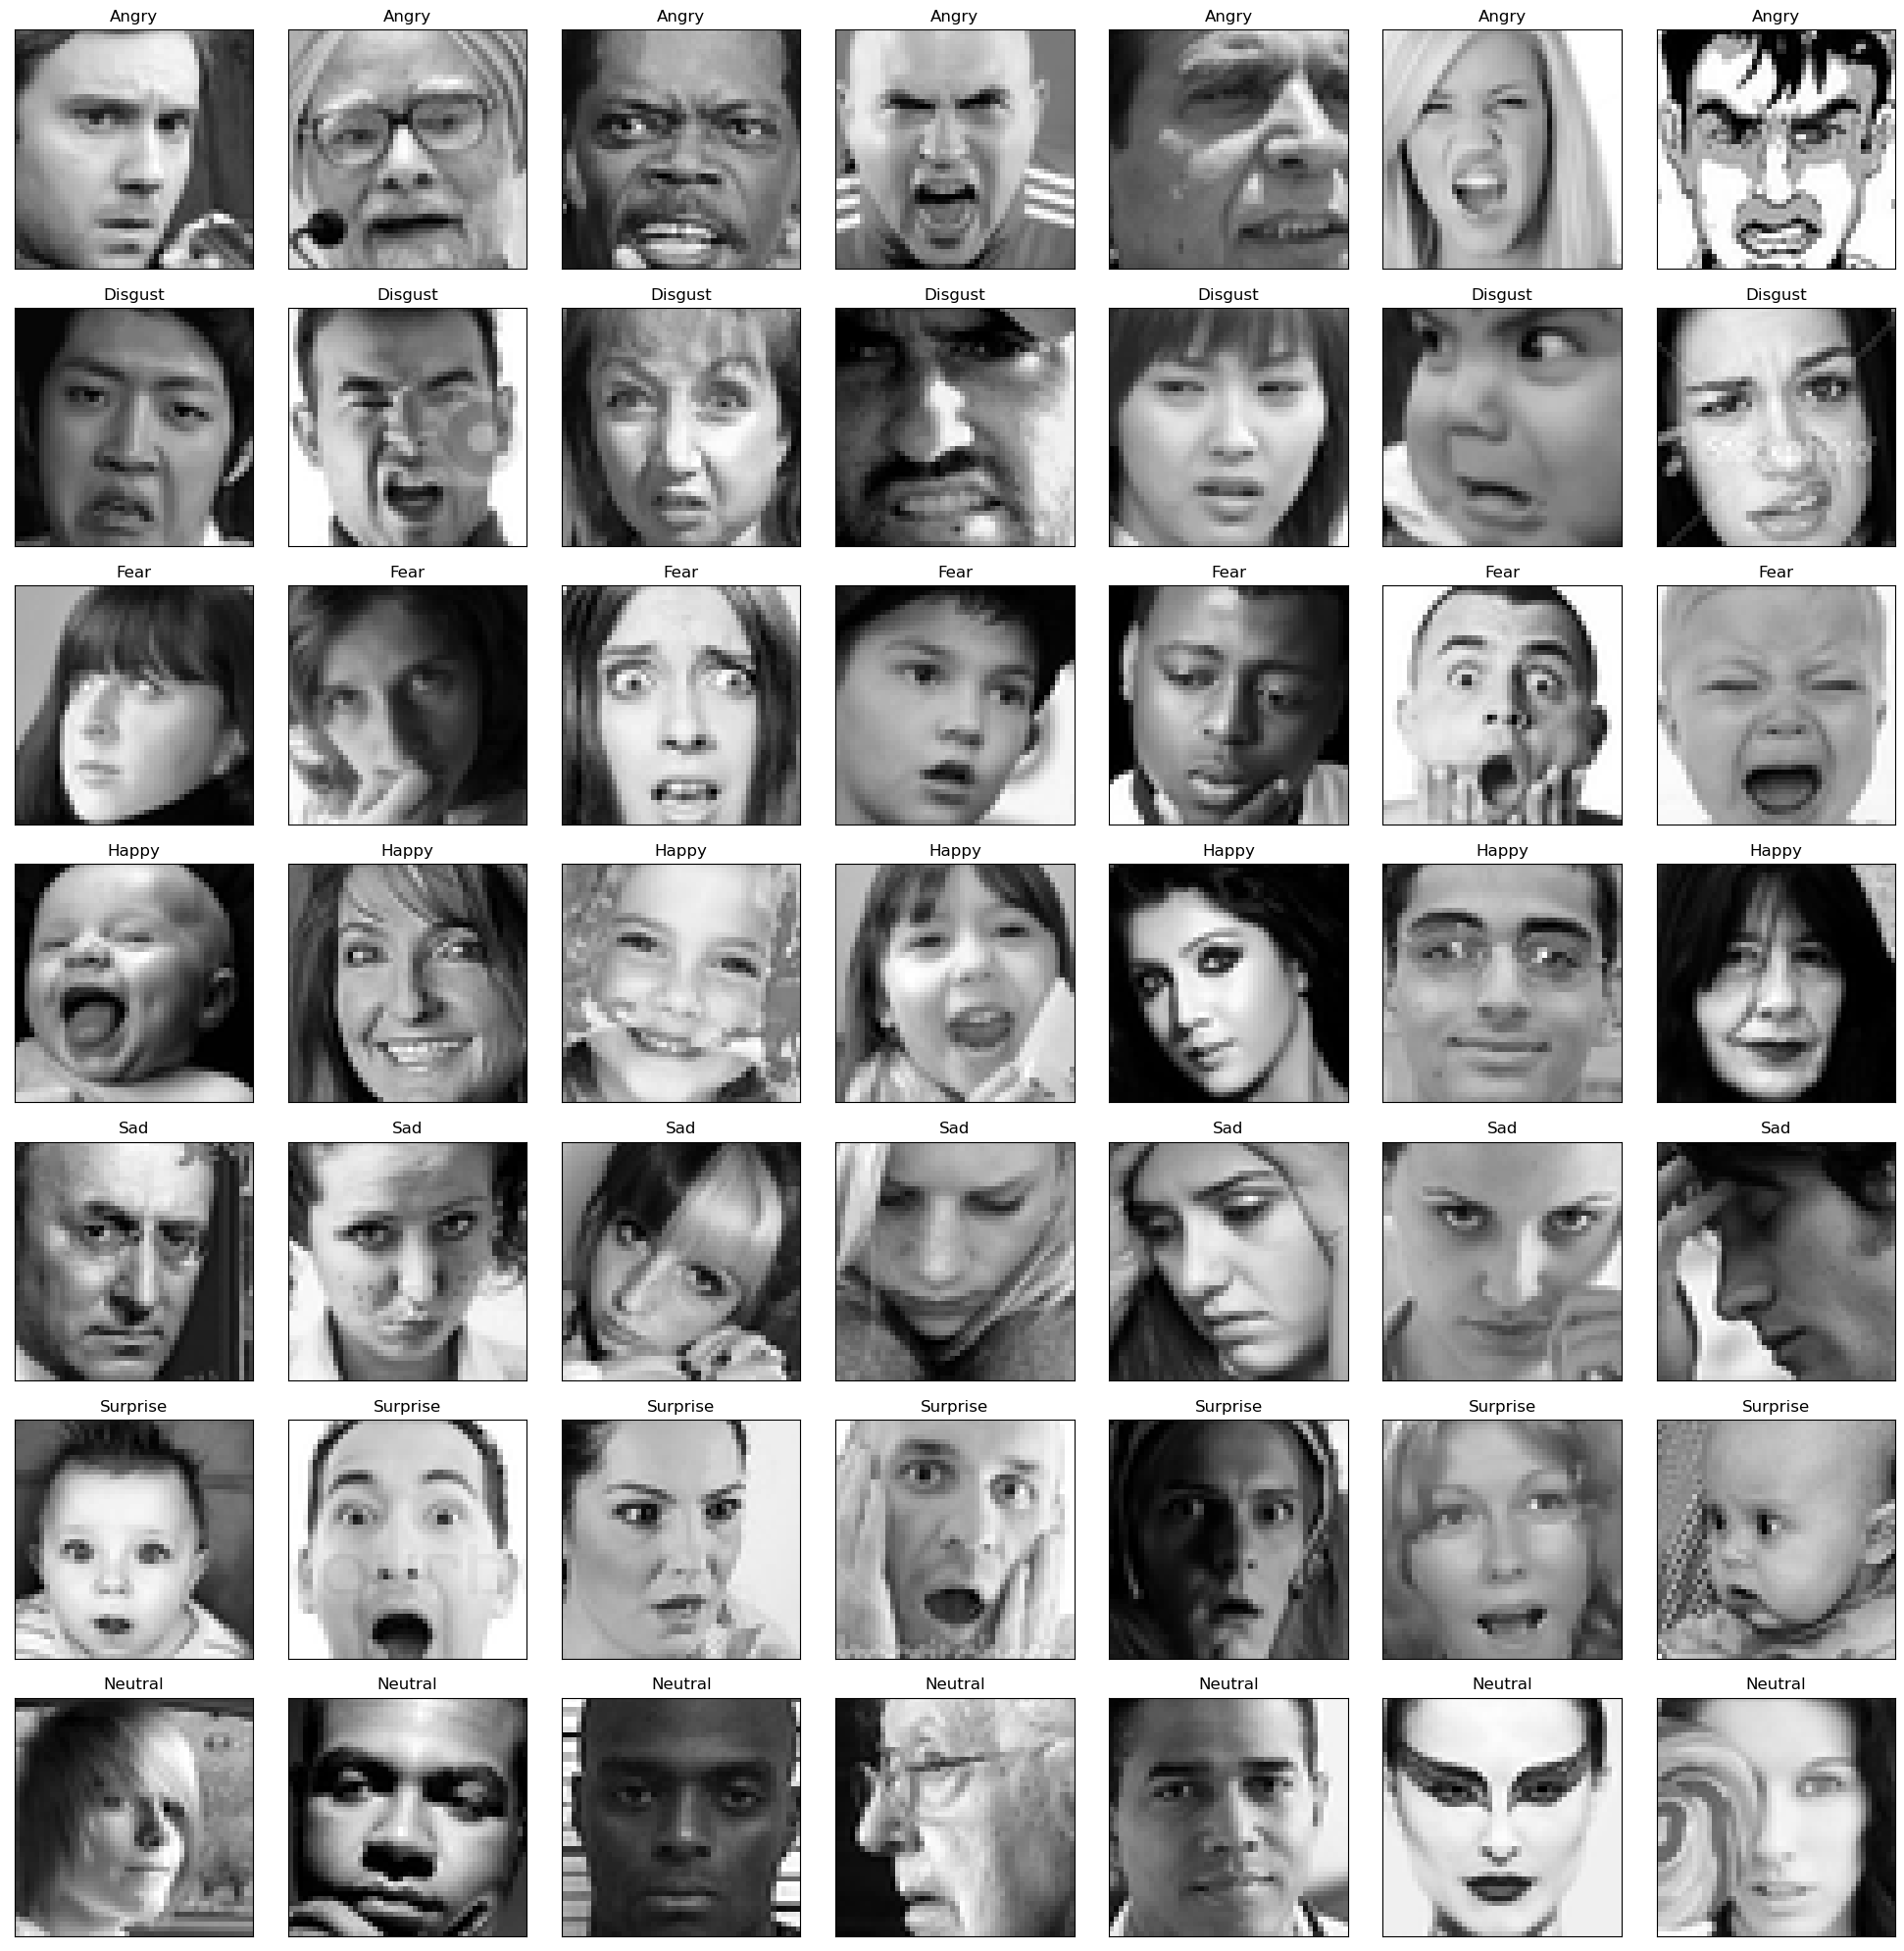

In [12]:
# visualize data
fig = plt.figure(1, (20, 20))

k = 0

for label in sorted(df['emotion'].unique()):
    for j in range(7):
        px = df[df['emotion'] == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        plt.tight_layout()

In [13]:
# prepare data
def prepare_data(df):
    img_array = np.zeros(shape=(len(df), 48, 48, 1))
    img_label = np.array(list(map(int, df['emotion'])))
    
    for i, row in enumerate(df.index):
        img = np.fromstring(df.loc[row, 'pixels'], dtype=int, sep=' ')
        img = np.reshape(img, (48, 48))
        img_array[i, :, :, 0] = img / 255
        
    return img_array, img_label

In [14]:
train_data = df[df.Usage == 'Training']
train_data.drop(columns='Usage', inplace=True)
train_data.head()

C:\Users\DELL\AppData\Local\Temp\ipykernel_6808\866434582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(columns='Usage', inplace=True)


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [15]:
X_train, y_train = prepare_data(train_data)
print(X_train.shape, y_train.shape)

(28709, 48, 48, 1) (28709,)


In [16]:
test_data = df[df.Usage == 'PublicTest']
test_data.drop(columns='Usage', inplace=True)
test_data.head()

C:\Users\DELL\AppData\Local\Temp\ipykernel_6808\3544976887.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(columns='Usage', inplace=True)


,emotion,pixels
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [17]:
X_test, y_test = prepare_data(test_data)
print(X_test.shape, y_test.shape)

(3589, 48, 48, 1) (3589,)


In [18]:
val_data = df[df.Usage == 'PrivateTest']
val_data.drop(columns='Usage', inplace=True)
val_data.head()

C:\Users\DELL\AppData\Local\Temp\ipykernel_6808\2127900557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data.drop(columns='Usage', inplace=True)


,emotion,pixels
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...


In [19]:
X_val, y_val = prepare_data(val_data)
print(X_val.shape, y_val.shape)

(3589, 48, 48, 1) (3589,)


In [20]:
# nomalize labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = le.fit_transform(y_test)
y_test = to_categorical(y_test)

y_val = le.fit_transform(y_val)
y_val = to_categorical(y_val)

In [21]:
# set model CNN
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', input_shape=(48, 48, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(128, (3,3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dense(32))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                        

In [25]:
opt = SGD(learning_rate=0.01, momentum=0.9)
# model.compile(optimizer=Adam(learning_rate= 1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
epochs = 15

batch_size = 64

checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='min')

earlystop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

callbacks = [earlystop, checkpoint, reduce_lr]

In [35]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), steps_per_epoch=len(X_train) / batch_size, epochs=epochs, callbacks=callbacks)

Epoch 1/15
449/448 [==============================] - ETA: 0s - loss: 1.4947 - accuracy: 0.4220
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 832s 2s/step - loss: 1.4947 - accuracy: 0.4220 - val_loss: 1.4098 - val_accuracy: 0.4578 - lr: 0.0100
Epoch 2/15
449/448 [==============================] - ETA: 0s - loss: 1.3028 - accuracy: 0.5040
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 1053s 2s/step - loss: 1.3028 - accuracy: 0.5040 - val_loss: 1.3433 - val_accuracy: 0.4854 - lr: 0.0100
Epoch 3/15
449/448 [==============================] - ETA: -1s - loss: 1.1754 - accuracy: 0.5553
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 1174s 3s/step - loss: 1.1754 - accuracy: 0.5553 - val_loss: 1.2627 - val_accuracy: 0.5093 - lr: 0.0100
Epoch 4/15
449/448 [==============================] - ETA: 0s - loss: 1.0684 - accuracy: 0.5966
Epoch 4: saving model to model_weights.h5
448/448 [=

KeyboardInterrupt: 

In [94]:
model.save('fer.h5')

In [22]:
fer_model = tf.keras.models.load_model('fer.h5')

In [23]:
results = fer_model.predict(X_test)

113/113 [==============================] - 27s 228ms/step


In [28]:
results = np.argmax(results, axis=1)
results

array([0, 0, 0, ..., 3, 4, 4], dtype=int64)

In [30]:
y_test1 = np.argmax(y_test, axis=1)
y_test1

array([0, 1, 4, ..., 4, 4, 4], dtype=int64)

In [33]:
cm = confusion_matrix(y_test1, results)
cm

array([[249,   4,  41,  39,  69,  10,  55],
       [ 13,  27,   6,   1,   7,   1,   1],
       [ 67,   0, 191,  33,  96,  46,  63],
       [ 33,   0,  27, 704,  36,  21,  74],
       [ 93,   1,  78,  55, 296,  15, 115],
       [ 25,   0,  34,  21,  13, 305,  17],
       [ 66,   2,  54,  57,  97,   7, 324]], dtype=int64)

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(flights, annot=True, fmt="d", linewidths=.5, ax=ax)